In [1]:
import mne
mne.viz.set_browser_backend("matplotlib")
from mne import concatenate_epochs, concatenate_raws
# mne.viz.set_3d_backend("notebook")
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
from mne_bids import BIDSPath, read_raw_bids
from itertools import product
from tqdm import tqdm
import os

Using matplotlib as 2D backend.


In [3]:
data_dir = '/mnt/sphere/projects/image_decoding_from_brain/THINGS-MEG-raw/download'
subject_file = data_dir + '/participants.tsv'
subjects = pd.read_csv(subject_file, sep="\t")
def get_subject_id(x):
    return x.split("-")[1]  # noqa
subjects = subjects.participant_id.apply(get_subject_id).values
subject = subjects[0]
tasks = ['main']
sessions = ['{:02d}'.format(x) for x in range(1,13)]  # 2 recording sessions
runs = ['{:02d}'.format(x) for x in range(1,11)]

In [4]:
def clipping(data, n_std = 5):
    a_min = data.mean() - n_std * data.std()
    a_max = data.mean() + n_std * data.std()
    return np.clip(data, a_min, a_max)

In [5]:
mag_ch_names = ['MLC11-1609','MLC12-1609','MLC13-1609','MLC14-1609','MLC15-1609','MLC16-1609','MLC17-1609','MLC21-1609','MLC22-1609','MLC23-1609','MLC24-1609','MLC25-1609','MLC31-1609','MLC32-1609','MLC41-1609','MLC42-1609','MLC51-1609','MLC52-1609','MLC53-1609','MLC54-1609','MLC55-1609','MLC61-1609','MLC62-1609','MLC63-1609',
 'MLF11-1609','MLF12-1609','MLF13-1609','MLF14-1609','MLF21-1609','MLF22-1609','MLF23-1609','MLF24-1609','MLF31-1609','MLF32-1609','MLF33-1609','MLF34-1609','MLF35-1609','MLF41-1609','MLF42-1609','MLF43-1609','MLF44-1609','MLF45-1609','MLF46-1609','MLF51-1609','MLF52-1609','MLF53-1609','MLF54-1609','MLF55-1609','MLF56-1609','MLF61-1609','MLF62-1609','MLF63-1609','MLF64-1609','MLF65-1609','MLF66-1609','MLF67-1609',
 'MLO11-1609','MLO12-1609','MLO13-1609','MLO14-1609','MLO21-1609','MLO22-1609','MLO23-1609','MLO24-1609','MLO31-1609','MLO32-1609','MLO33-1609','MLO34-1609','MLO41-1609','MLO42-1609','MLO43-1609','MLO44-1609','MLO51-1609','MLO52-1609','MLO53-1609',
 'MLP11-1609','MLP12-1609','MLP21-1609','MLP22-1609','MLP23-1609','MLP31-1609','MLP32-1609','MLP33-1609','MLP34-1609','MLP35-1609','MLP41-1609','MLP42-1609','MLP43-1609','MLP44-1609','MLP45-1609','MLP51-1609','MLP52-1609','MLP53-1609','MLP54-1609','MLP55-1609','MLP56-1609','MLP57-1609',
 'MLT11-1609','MLT12-1609','MLT13-1609','MLT14-1609','MLT15-1609','MLT16-1609','MLT21-1609','MLT22-1609','MLT23-1609','MLT24-1609','MLT25-1609','MLT26-1609','MLT27-1609','MLT31-1609','MLT32-1609','MLT33-1609','MLT34-1609','MLT35-1609','MLT36-1609','MLT37-1609','MLT41-1609','MLT42-1609','MLT43-1609','MLT44-1609','MLT45-1609','MLT46-1609','MLT47-1609','MLT51-1609','MLT52-1609','MLT53-1609','MLT54-1609','MLT55-1609','MLT56-1609','MLT57-1609',
 'MRC11-1609','MRC12-1609','MRC13-1609','MRC14-1609','MRC15-1609','MRC16-1609','MRC17-1609','MRC21-1609','MRC22-1609','MRC23-1609','MRC24-1609','MRC25-1609','MRC31-1609','MRC32-1609','MRC41-1609','MRC42-1609','MRC51-1609','MRC52-1609','MRC53-1609','MRC54-1609','MRC55-1609','MRC61-1609','MRC62-1609','MRC63-1609',
 'MRF11-1609','MRF12-1609','MRF13-1609','MRF14-1609','MRF21-1609','MRF22-1609','MRF23-1609','MRF24-1609','MRF25-1609','MRF31-1609','MRF32-1609','MRF33-1609','MRF34-1609','MRF35-1609','MRF41-1609','MRF42-1609','MRF44-1609','MRF45-1609','MRF46-1609','MRF51-1609','MRF52-1609','MRF53-1609','MRF54-1609','MRF55-1609','MRF56-1609','MRF61-1609','MRF62-1609','MRF63-1609','MRF64-1609','MRF65-1609','MRF66-1609','MRF67-1609',
 'MRO11-1609','MRO12-1609','MRO14-1609','MRO21-1609','MRO22-1609','MRO23-1609','MRO24-1609','MRO31-1609','MRO32-1609','MRO33-1609','MRO34-1609','MRO41-1609','MRO42-1609','MRO43-1609','MRO44-1609','MRO51-1609','MRO52-1609','MRO53-1609',
 'MRP11-1609', 'MRP12-1609', 'MRP21-1609', 'MRP22-1609', 'MRP23-1609', 'MRP31-1609', 'MRP32-1609', 'MRP33-1609', 'MRP34-1609', 'MRP35-1609', 'MRP41-1609', 'MRP42-1609', 'MRP43-1609', 'MRP44-1609', 'MRP45-1609', 'MRP51-1609', 'MRP52-1609', 'MRP53-1609', 'MRP54-1609', 'MRP55-1609', 'MRP56-1609','MRP57-1609',
 'MRT11-1609', 'MRT12-1609', 'MRT13-1609', 'MRT14-1609', 'MRT15-1609', 'MRT16-1609', 'MRT21-1609', 'MRT22-1609', 'MRT23-1609', 'MRT24-1609', 'MRT25-1609', 'MRT26-1609', 'MRT27-1609', 'MRT31-1609', 'MRT32-1609', 'MRT33-1609', 'MRT34-1609', 'MRT35-1609', 'MRT36-1609', 'MRT37-1609', 'MRT41-1609', 'MRT42-1609', 'MRT43-1609', 'MRT44-1609', 'MRT45-1609', 'MRT46-1609', 'MRT47-1609', 'MRT51-1609', 'MRT52-1609', 'MRT53-1609', 'MRT54-1609', 'MRT55-1609', 'MRT56-1609', 'MRT57-1609',
 'MZC01-1609', 'MZC02-1609', 'MZC03-1609', 'MZC04-1609',
 'MZF01-1609','MZF02-1609','MZF03-1609',
 'MZO01-1609','MZO02-1609','MZO03-1609',
 'MZP01-1609']
ch_type_map = {'UPPT001': 'stim'}
ch_type_map.update({x: 'mag' for x in mag_ch_names})

In [6]:
labels = np.load('data/things_text_labels.npy', mmap_mode='r')

In [ ]:
raw_list = []
for session, task, run in tqdm(product(sessions, tasks, runs), total=len(sessions)*len(tasks)*len(runs)):
    bids_path = BIDSPath(
        subject=subject,
        session=session,
        task=task,
        root=data_dir,
        run = run,
        datatype="meg",
    )
    raw = read_raw_bids(bids_path, verbose='ERROR')
    raw.set_channel_types(ch_type_map, verbose='ERROR')
    raw_list.append(raw)
    
raws = concatenate_raws(raw_list, on_mismatch="ignore")
index1b_list = [int(float(i.split('/')[-1])) - 1 if '/' in i else -1 for i in raws.annotations.description]
combined_annot = np.array([item if item in ['catch', 'BAD boundary', 'EDGE boundary'] else f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}' for i, item in enumerate(raws.annotations.description)])
raws.annotations.rename(dict(zip(raws.annotations.description, combined_annot)))
_, all_event_dict = mne.events_from_annotations(raws, verbose='ERROR')

In [54]:
all_event_dict

{'catch': 1,
 'exp/aardvark/1.0': 2,
 'exp/aardvark/10.0': 3,
 'exp/aardvark/11.0': 4,
 'exp/aardvark/12.0': 5,
 'exp/aardvark/2.0': 6,
 'exp/aardvark/3.0': 7,
 'exp/aardvark/4.0': 8,
 'exp/aardvark/5.0': 9,
 'exp/aardvark/6.0': 10,
 'exp/aardvark/7.0': 11,
 'exp/aardvark/8.0': 12,
 'exp/aardvark/9.0': 13,
 'exp/abacus/15.0': 14,
 'exp/abacus/16.0': 15,
 'exp/abacus/17.0': 16,
 'exp/abacus/18.0': 17,
 'exp/abacus/19.0': 18,
 'exp/abacus/20.0': 19,
 'exp/abacus/21.0': 20,
 'exp/abacus/22.0': 21,
 'exp/abacus/23.0': 22,
 'exp/abacus/24.0': 23,
 'exp/abacus/25.0': 24,
 'exp/abacus/26.0': 25,
 'exp/accordion/29.0': 26,
 'exp/accordion/30.0': 27,
 'exp/accordion/31.0': 28,
 'exp/accordion/32.0': 29,
 'exp/accordion/33.0': 30,
 'exp/accordion/34.0': 31,
 'exp/accordion/35.0': 32,
 'exp/accordion/36.0': 33,
 'exp/accordion/37.0': 34,
 'exp/accordion/38.0': 35,
 'exp/accordion/39.0': 36,
 'exp/accordion/40.0': 37,
 'exp/acorn/43.0': 38,
 'exp/acorn/44.0': 39,
 'exp/acorn/45.0': 40,
 'exp/acorn

In [58]:
i_iter = 0
epoch_list = []
for session, task, run in tqdm(product(sessions, tasks, runs), total=len(sessions)*len(tasks)*len(runs)):
    bids_path = BIDSPath(
        subject=subject,
        session=session,
        task=task,
        root=data_dir,
        run = run,
        datatype="meg",
    )
    raw = read_raw_bids(bids_path, verbose='ERROR')
    raw.set_channel_types(ch_type_map, verbose='ERROR')
    index1b_list = [int(float(i.split('/')[-1])) - 1 if '/' in i else -1 for i in raw.annotations.description]
    # combined_annot = np.array([item if item == 'catch' else f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}' for i, item in enumerate(raw.annotations.description)])
    combined_annot = np.array([item if item in ['catch', 'BAD boundary', 'EDGE boundary'] else f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}' for i, item in enumerate(raw.annotations.description)])
    raw.annotations.rename(dict(zip(raw.annotations.description, combined_annot)))
    # events, event_dict = mne.events_from_annotations(raw, verbose='ERROR')
    events, event_dict = mne.events_from_annotations(raw, verbose='ERROR', event_id=all_event_dict)
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=False, picks='mag', verbose='ERROR')
    # epochs.resample(120, npad="auto", verbose='ERROR', n_jobs='cuda')
    # epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
    # epochs.filter(0, 40, verbose=False, n_jobs='cuda');
    # epochs.apply_function(clipping, n_std = 5, verbose=False);
    epoch_list.append(epochs)
    if i_iter == 5:
        break
    i_iter += 1

  4%|▍         | 5/120 [00:47<18:06,  9.45s/it]


In [59]:
all_epochs = concatenate_epochs(epoch_list, on_mismatch="ignore") # head positions are different in each run

/tmp/ipykernel_980645/3932468985.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = concatenate_epochs(epoch_list, on_mismatch="ignore") # head positions are different in each run


Loading data for 226 events and 1561 original time points ...
0 bad epochs dropped
Loading data for 226 events and 1561 original time points ...
0 bad epochs dropped
Loading data for 226 events and 1561 original time points ...
0 bad epochs dropped
Loading data for 226 events and 1561 original time points ...
0 bad epochs dropped
Loading data for 225 events and 1561 original time points ...
0 bad epochs dropped
Loading data for 225 events and 1561 original time points ...
0 bad epochs dropped
Loading data for 226 events and 1561 original time points ...
Loading data for 226 events and 1561 original time points ...


In [23]:
all_epochs.save('cache/processed_data/BIGMEG1/epochs_10runs-epo.fif.gz',split_naming='bids')

Splitting into 2 parts


In [ ]:
# for i, item in enumerate(raws.annotations.description):
#     if item in ['catch', 'BAD boundary', 'EDGE boundary']:
#         pass
#     else:
#         print(f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}')

In [23]:
all_epochs = mne.read_epochs('cache/processed_data/BIGMEG1/epochs/epochs_meg_split-01_epo.fif.gz',preload=True)

Reading /mnt/sphere/projects/simon/meg-decoding/cache/processed_data/BIGMEG1/epochs/epochs_meg_split-01_epo.fif.gz ...
    Found the data of interest:
        t =       0.00 ...     991.67 ms
        0 CTF compensation matrices available
Reading /mnt/sphere/projects/simon/meg-decoding/cache/processed_data/BIGMEG1/epochs/epochs_meg_split-02_epo.fif.gz ...
    Found the data of interest:
        t =       0.00 ...     991.67 ms
        0 CTF compensation matrices available
Not setting metadata
27048 matching events found
No baseline correction applied
0 projection items activated


In [17]:
test_labels = np.array(list(all_epochs['test'].event_id.keys()))

In [24]:
all_epochs[test_labels[0]].average().get_data().shape

(272, 120)

In [33]:
int(float(test_labels[0].split('/')[-1])) - 1

1793

In [34]:
averaged_epochs = np.zeros((len(test_labels), 272, 120))
image_ids = np.zeros(len(test_labels))
text_labels = []
for i, label in enumerate(test_labels):
    averaged_epochs[i] = all_epochs[label].average().get_data()
    image_ids[i] = int(float(label.split('/')[-1])) - 1
    text_labels.append(label.split('/')[1])
test_labels = np.array(text_labels)

In [41]:
np.save('cache/processed_data/BIGMEG1/test_avg_thingsmeg_sub-BIGMEG1.npy', averaged_epochs)

In [39]:
np.save('cache/processed_data/BIGMEG1/test_avg_labels1b_sub-BIGMEG1.npy', test_labels)
np.save('cache/processed_data/BIGMEG1/test_avg_image_ids1b_sub-BIGMEG1.npy', image_ids)

In [37]:
stim_images = np.load('data/things_stim_images.npy', mmap_mode='r')
test_images = stim_images[image_ids.astype(int)]

In [40]:
np.save('cache/processed_data/BIGMEG1/test_avg_images1b_sub-BIGMEG1.npy', test_images)

In [2]:
test_labels = np.load('cache/processed_data/BIGMEG1/test_avg_labels1b_sub-BIGMEG1.npy')

In [3]:
test_labels

array(['bell', 'boxer shorts', 'camel', 'cheetah', 'closet', 'crayon',
       'dough', 'eggbeater', 'floss', 'limousine', 'milkshake',
       'mosquito', 'pothole', 'road sign', 'starfish', 'toothpick',
       'typewriter', 'waffle iron', 'wallpaper', 'wasp', 'bear', 'bike',
       'cookie', 'cow', 'cymbal', 'dolly', 'dragonfly', 'fish', 'grape',
       'hairbrush', 'horseshoe', 'jam', 'lawnmower', 'meat', 'pan', 'pie',
       'telescope', 'tiramisu', 'treadmill', 'urinal', 'altar', 'axe',
       'banana', 'bed', 'butterfly', 'cardigan', 'chipmunk', 'crib',
       'cupcake', 'fudge', 'headphones', 'iron', 'jar', 'knife',
       'oatmeal', 'screwdriver', 'sewing kit', 'taco', 'thumbtack',
       'tomato', 'aluminum foil', 'bagel', 'ball', 'caterpillar',
       'cheese', 'clipboard', 'couch', 'dress', 'ferris wheel', 'gel',
       'hay', 'helicopter', 'mango', 'mosquito net', 'nest', 'pacifier',
       'ribbon', 'shell', 'tuxedo', 'whip', 'beaver', 'blowtorch',
       'drain', 'drawer', 

In [119]:
# i_iter = 0
raw_list = []
for session, task, run in tqdm(product(sessions, tasks, runs), total=len(sessions)*len(tasks)*len(runs)):
    bids_path = BIDSPath(
        subject=subject,
        session=session,
        task=task,
        root=data_dir,
        run = run,
        datatype="meg",
    )
    raw = read_raw_bids(bids_path, verbose='ERROR')
    raw.set_channel_types(ch_type_map, verbose='ERROR')
    raw_list.append(raw)
    # if i_iter == 10:
    #     break
    # i_iter += 1
    
raws = concatenate_raws(raw_list, on_mismatch="ignore")
# index1b_list = [int(float(i.split('/')[-1])) - 1 if '/' in i else -1 for i in raws.annotations.description]
# combined_annot = np.array([item if item == 'catch' else f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}' for i, item in enumerate(raw.annotations.description)])
# raws.annotations.rename(dict(zip(raws.annotations.description, combined_annot)))
_, event_dict = mne.events_from_annotations(raws, verbose='ERROR')
# epochs = mne.Epochs(raws, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=True, picks='mag', verbose='ERROR').resample(120, npad="auto", verbose='ERROR', n_jobs=500)
# epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
# epochs.filter(0, 40, verbose=False, n_jobs=500);
# epochs.apply_function(clipping, n_std = 5, verbose=False);

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [05:26<00:00,  2.72s/it]


In [118]:
event_dict.values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [89]:
train_meg = None
test_meg = None
i_iter = 0
epoch_list = []
for session, task, run in tqdm(product(sessions, tasks, runs), total=len(sessions)*len(tasks)*len(runs)):
    bids_path = BIDSPath(
        subject=subject,
        session=session,
        task=task,
        root=data_dir,
        run = run,
        datatype="meg",
    )
    raw = read_raw_bids(bids_path, verbose='ERROR')
    raw.set_channel_types(ch_type_map, verbose='ERROR')
    # raw.annotations.rename({'exp/10046.0':'exp/car/10046.0', 'exp/1014.0':'exp/car/1014.0'})
    # raw.annotations.description[0] = 'exp/carrr/24812.0'
    index1b_list = [int(float(i.split('/')[-1])) - 1 if '/' in i else -1 for i in raw.annotations.description]
    combined_annot = np.array([item if item == 'catch' else f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}' for i, item in enumerate(raw.annotations.description)])
    raw.annotations.rename(dict(zip(raw.annotations.description, combined_annot)))
    events, event_dict = mne.events_from_annotations(raw, verbose='ERROR')
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=True, picks='mag', verbose='ERROR').resample(120, npad="auto", verbose='ERROR')
    # epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
    epochs.filter(0, 40, verbose=False);
    epochs.apply_function(clipping, n_std = 5, verbose=False);
    epoch_list.append(epochs)
    # if train_meg is None:
    #     train_meg = epochs['exp'].get_data(copy=True)
    #     test_meg = epochs['test'].get_data(copy=True)
    # else:
    #     train_meg = np.concatenate((train_meg, epochs['exp'].get_data(copy=True)), axis=0)
    #     test_meg = np.concatenate((test_meg, epochs['test'].get_data(copy=True)), axis=0)
    if i_iter == 0:
        break
    i_iter += 1
# bids_path

  0%|          | 0/120 [01:40<?, ?it/s]


In [6]:
train_meg.shape, test_meg.shape

((186, 272, 60), (20, 272, 60))

In [90]:
all_epochs = concatenate_epochs(epoch_list, on_mismatch="ignore") # head positions are different in each run

Not setting metadata
226 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_958961/3932468985.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = concatenate_epochs(epoch_list, on_mismatch="ignore") # head positions are different in each run


In [91]:
# all_epochs['test/dolly'].average().plot();

In [92]:
# all_epochs['test/crayon'].average().plot();

In [72]:
epochs[1].info['dev_head_t']

<Transform | MEG device->head>
[[ 0.99993971  0.01098082  0.00006487 -0.0009674 ]
 [-0.01097007  0.99866166  0.05054248 -0.01849388]
 [ 0.00049022 -0.05054014  0.99872191  0.04896332]
 [ 0.          0.          0.          1.        ]]

In [55]:
# raw.annotations.description
# index1b_list = [int(float(i.split('/')[-1])) - 1 for i in raw.annotations.description if '/' in i]
# index1b_list = [int(float(i.split('/')[-1])) - 1 if '/' in i else -1 for i in raw.annotations.description]

In [50]:
# prefixes = [i.split('/')[0] for i in raw.annotations.description if '/' in i]

In [60]:
# combined_annot = np.array([item if item == 'catch' else f'{item.split("/")[0]}/{labels[index1b_list][i]}/{item.split("/")[1]}' for i, item in enumerate(raw.annotations.description)])

In [61]:
# raw.annotations.rename(dict(zip(raw.annotations.description, combined_annot)))

<Annotations | 226 segments: catch (20), exp/anklet/341.0 (1), ...>

In [46]:
# labels[index1b_list]
# combined_array = np.array([f'exp/{s}/{n}' for s, n in zip(labels[index1b_list], index1b_list)])

In [32]:
# epochs['exp/carrr']

Number of events,1
Events,exp/carrr/24: 1
Time range,0.000 – 0.992 s
Baseline,-0.300 – 0.000 s


In [7]:
# save_dir = 'cache/processed_data/' + subject + '/'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# np.save(save_dir + f'train_thingsmeg_sub-{subject}.npy', train_meg)
# np.save(save_dir + f'test_thingsmeg_sub-{subject}.npy', test_meg)

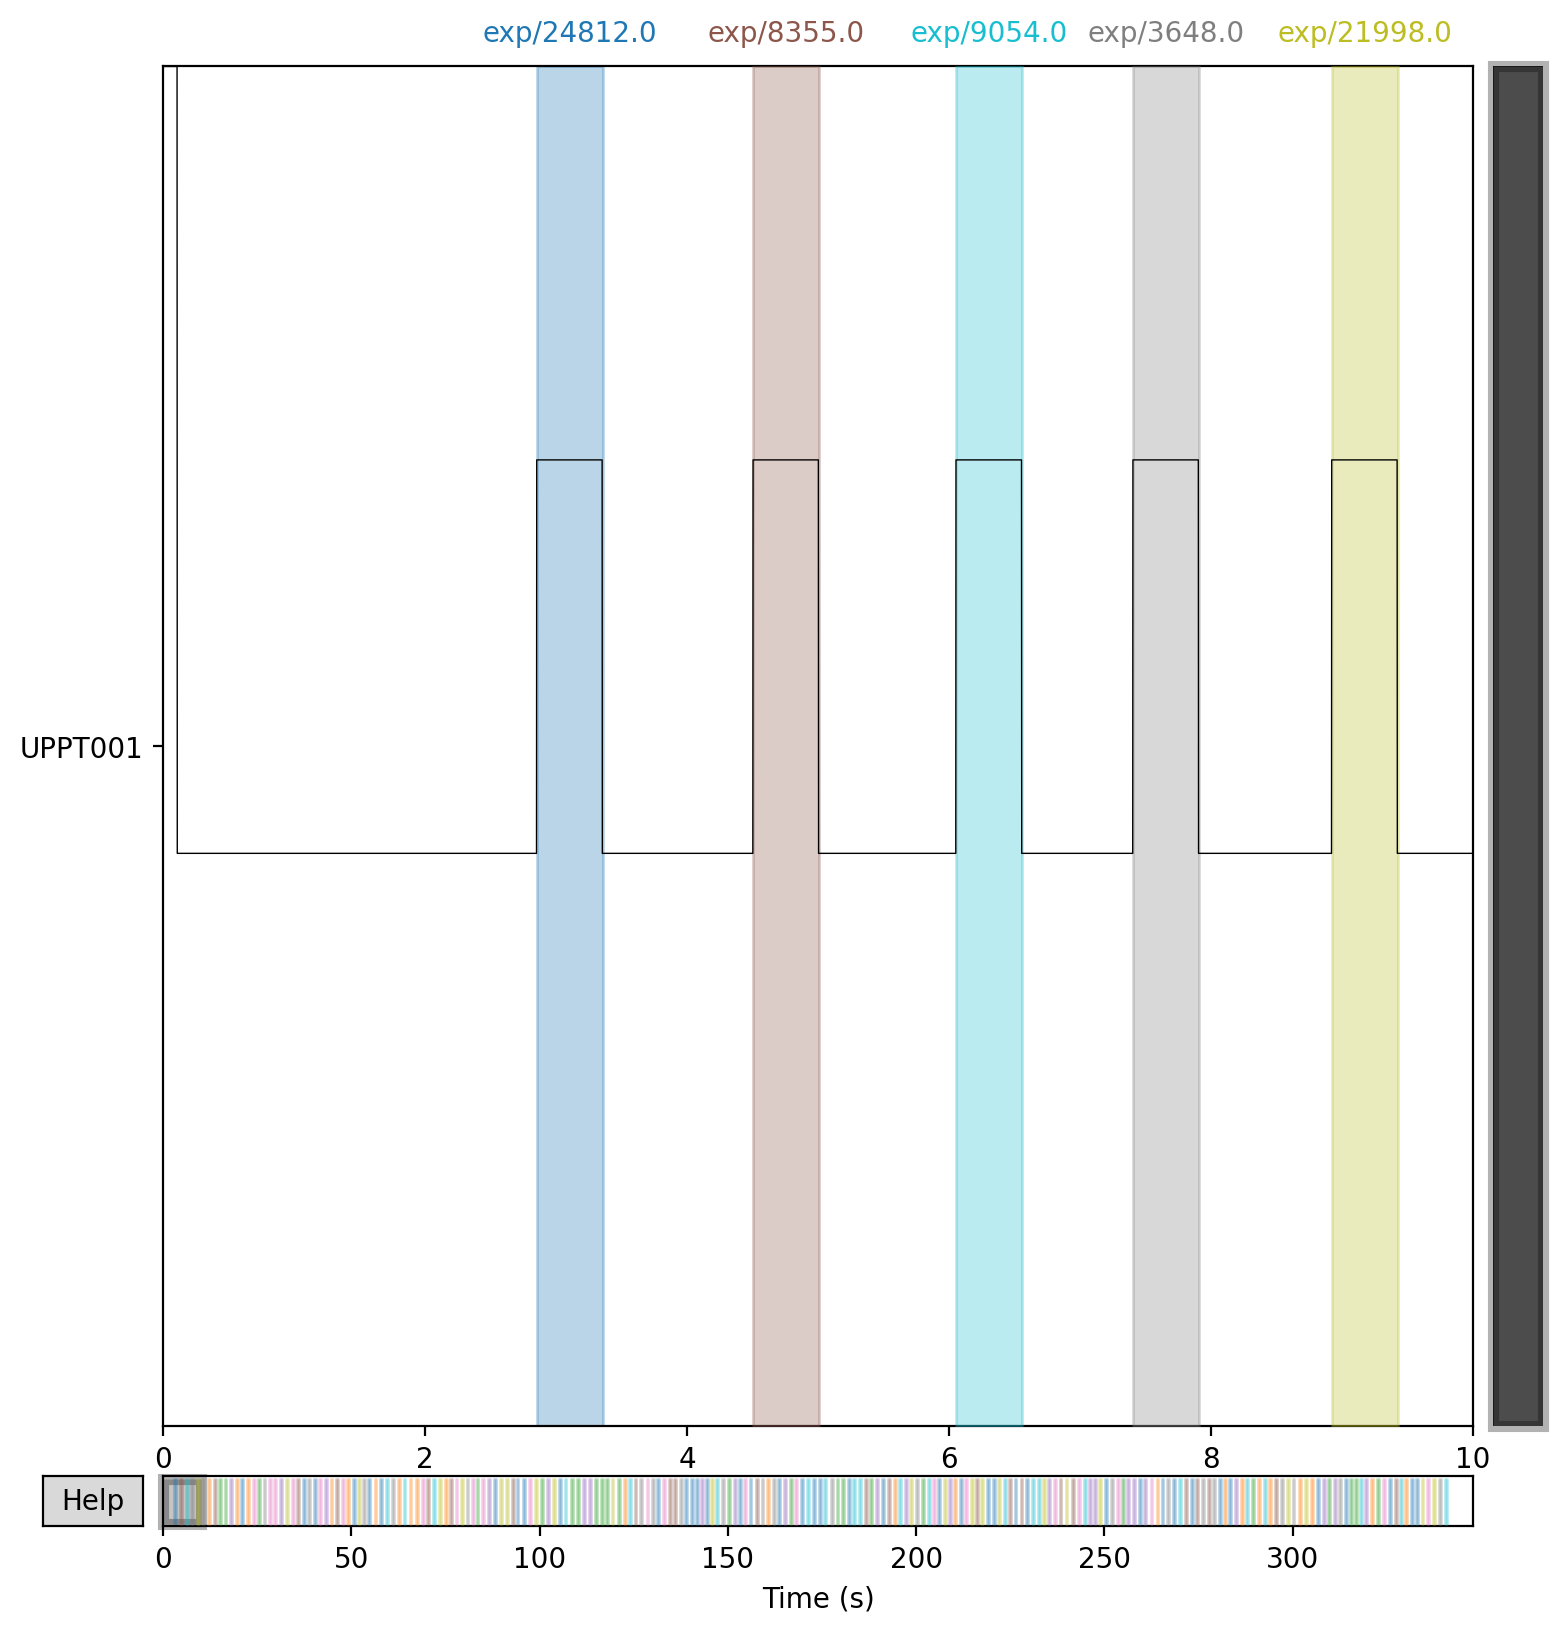

In [6]:
raw.pick('stim').plot();

In [12]:
f'train_thingsmeg_sub-{subject}.npy'

'train_thingsmeg_sub-BIGMEG1.npy'

In [6]:
ch_type_map = {'UPPT001': 'stim'}
ch_type_map.update({x: 'mag' for x in mag_ch_names})

In [7]:
raw.set_channel_types(ch_type_map)

/tmp/ipykernel_3203178/1938683839.py:1: RuntimeWarning: The unit for channel(s) UPPT001 has changed from NA to V.
  raw.set_channel_types(ch_type_map)
/tmp/ipykernel_3203178/1938683839.py:1: RuntimeWarning: The unit for channel(s) MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, MLC16-1609, MLC17-1609, MLC21-1609, MLC22-1609, MLC23-1609, MLC24-1609, MLC25-1609, MLC31-1609, MLC32-1609, MLC41-1609, MLC42-1609, MLC51-1609, MLC52-1609, MLC53-1609, MLC54-1609, MLC55-1609, MLC61-1609, MLC62-1609, MLC63-1609, MLF11-1609, MLF12-1609, MLF13-1609, MLF14-1609, MLF21-1609, MLF22-1609, MLF23-1609, MLF24-1609, MLF31-1609, MLF32-1609, MLF33-1609, MLF34-1609, MLF35-1609, MLF41-1609, MLF42-1609, MLF43-1609, MLF44-1609, MLF45-1609, MLF46-1609, MLF51-1609, MLF52-1609, MLF53-1609, MLF54-1609, MLF55-1609, MLF56-1609, MLF61-1609, MLF62-1609, MLF63-1609, MLF64-1609, MLF65-1609, MLF66-1609, MLF67-1609, MLO11-1609, MLO12-1609, MLO13-1609, MLO14-1609, MLO21-1609, MLO22-1609, MLO23-1609, MLO24-1609, M

Measurement date,"June 13, 2019 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-BIGMEG1
Digitized points,3 points
Good channels,"9 misc, 28 Reference Magnetometers, 272 Magnetometers, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1200.00 Hz
Highpass,0.00 Hz
Lowpass,600.00 Hz


Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


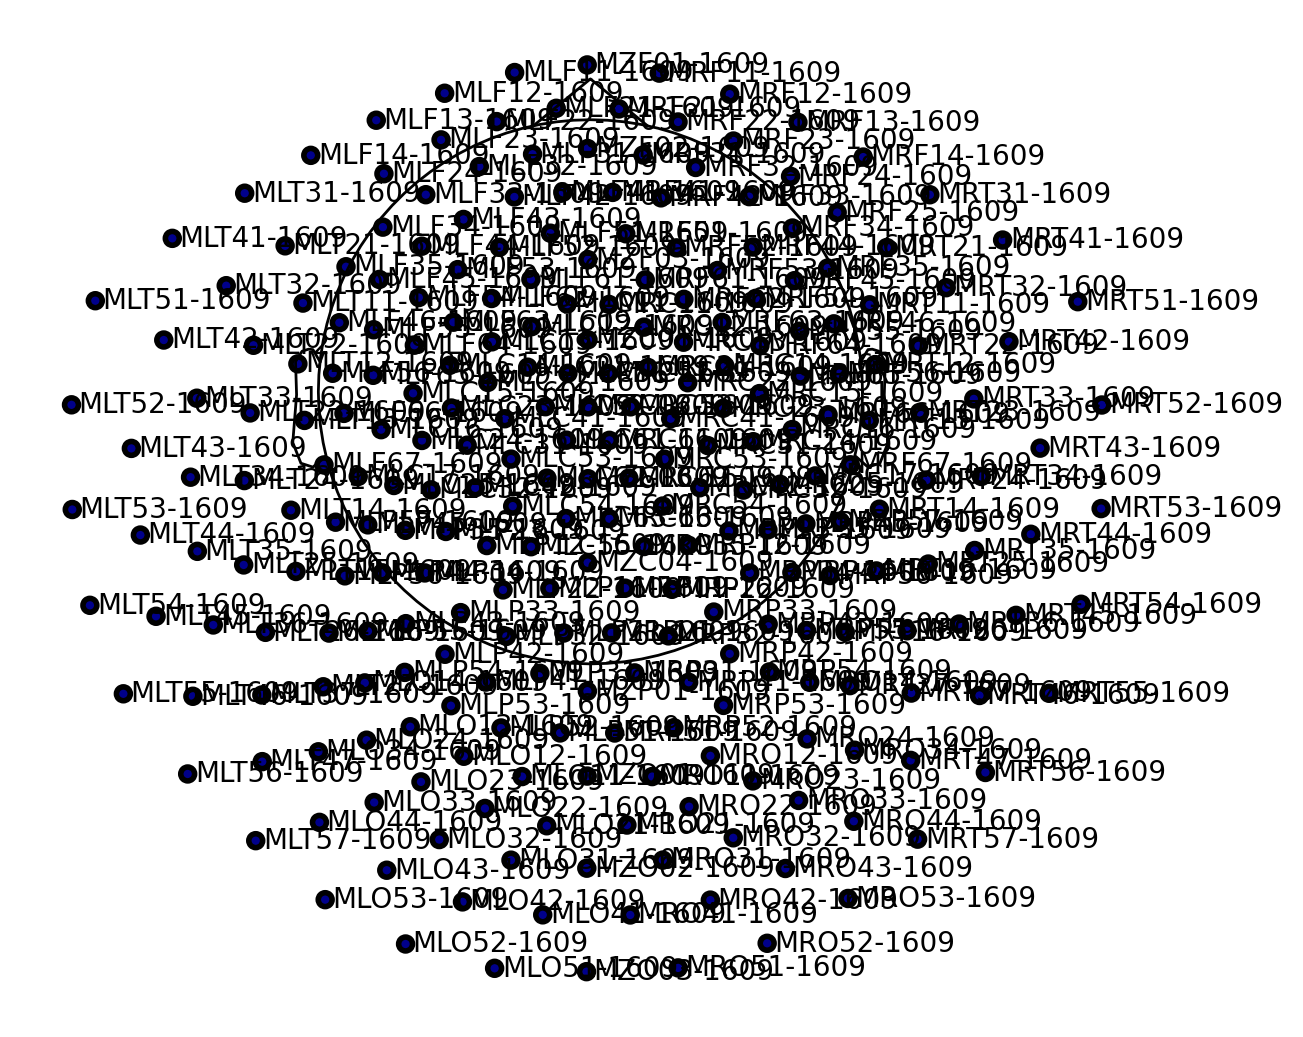

In [8]:
raw.plot_sensors(kind='topomap', ch_type= 'mag', show_names=True);

In [16]:
events, event_dict = mne.events_from_annotations(raw)

Used Annotations descriptions: ['catch', 'exp/10046.0', 'exp/1014.0', 'exp/10216.0', 'exp/10271.0', 'exp/1042.0', 'exp/10869.0', 'exp/11027.0', 'exp/11145.0', 'exp/11379.0', 'exp/11745.0', 'exp/11837.0', 'exp/11900.0', 'exp/12115.0', 'exp/12130.0', 'exp/12342.0', 'exp/12389.0', 'exp/12401.0', 'exp/12419.0', 'exp/12791.0', 'exp/12889.0', 'exp/12901.0', 'exp/12941.0', 'exp/13129.0', 'exp/13167.0', 'exp/1329.0', 'exp/13595.0', 'exp/13610.0', 'exp/13695.0', 'exp/13834.0', 'exp/13874.0', 'exp/14029.0', 'exp/14257.0', 'exp/14269.0', 'exp/14424.0', 'exp/14569.0', 'exp/14744.0', 'exp/14811.0', 'exp/15050.0', 'exp/15245.0', 'exp/16202.0', 'exp/16290.0', 'exp/16327.0', 'exp/16495.0', 'exp/16568.0', 'exp/16808.0', 'exp/16838.0', 'exp/16926.0', 'exp/1704.0', 'exp/17387.0', 'exp/17420.0', 'exp/17435.0', 'exp/17462.0', 'exp/17541.0', 'exp/17624.0', 'exp/1807.0', 'exp/18206.0', 'exp/1835.0', 'exp/18416.0', 'exp/18595.0', 'exp/18627.0', 'exp/18706.0', 'exp/18855.0', 'exp/19142.0', 'exp/19156.0', 'exp/

In [118]:
def clipping(data, n_std = 5):
    # sem = data.std() / np.sqrt(len(data)) # standard error of the mean
    # sem = data.std() / np.sqrt(1)
    # a_min = data.mean() - n_sem * sem
    # a_max = data.mean() + n_sem * sem
    a_min = data.mean() - n_std * data.std()
    a_max = data.mean() + n_std * data.std()
    return np.clip(data, a_min, a_max)

In [121]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=True, picks='mag').resample(120, npad="auto")
epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=0.0, tmax=1.0, baseline=None, detrend=0, preload=True, picks='mag').resample(120, npad="auto")
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=0.0, tmax=1.0, baseline=(0, 0.5), preload=True, picks='mag').resample(120, npad="auto")
epochs.filter(0, 40, verbose=False);
epochs.apply_function(clipping, n_std = 5, verbose=False);

Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 226 events and 1561 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


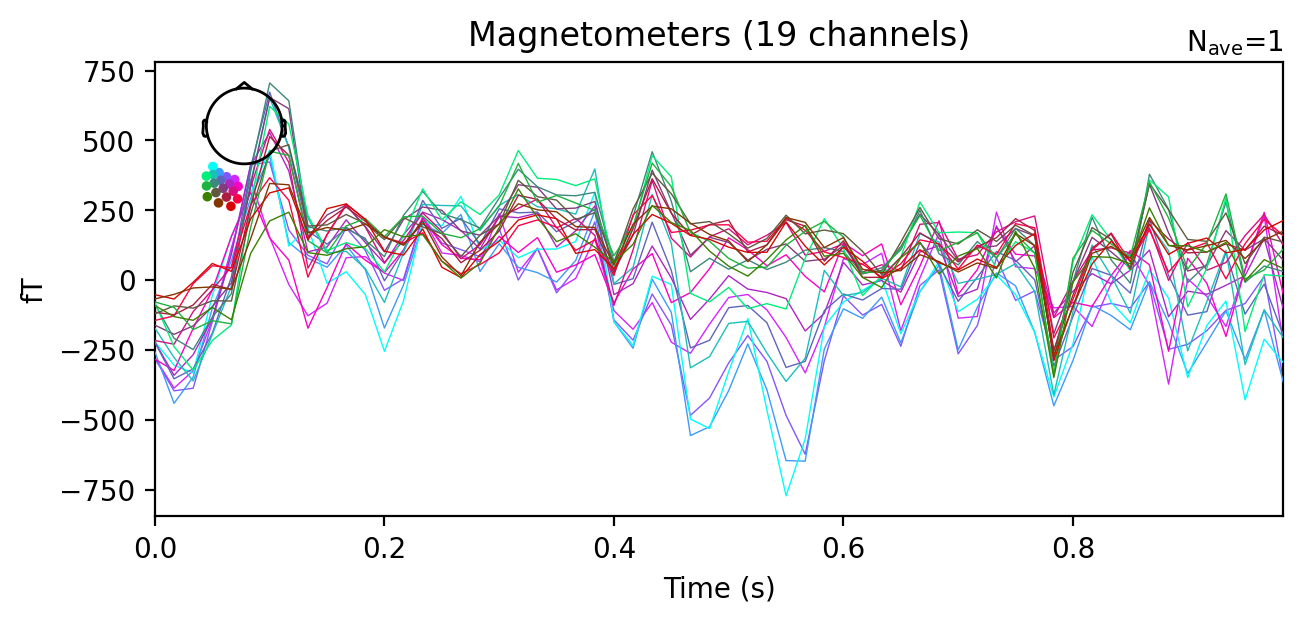

In [6]:
epochs[1].pick_channels(mag_ch_names[56:75]).average().plot();

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


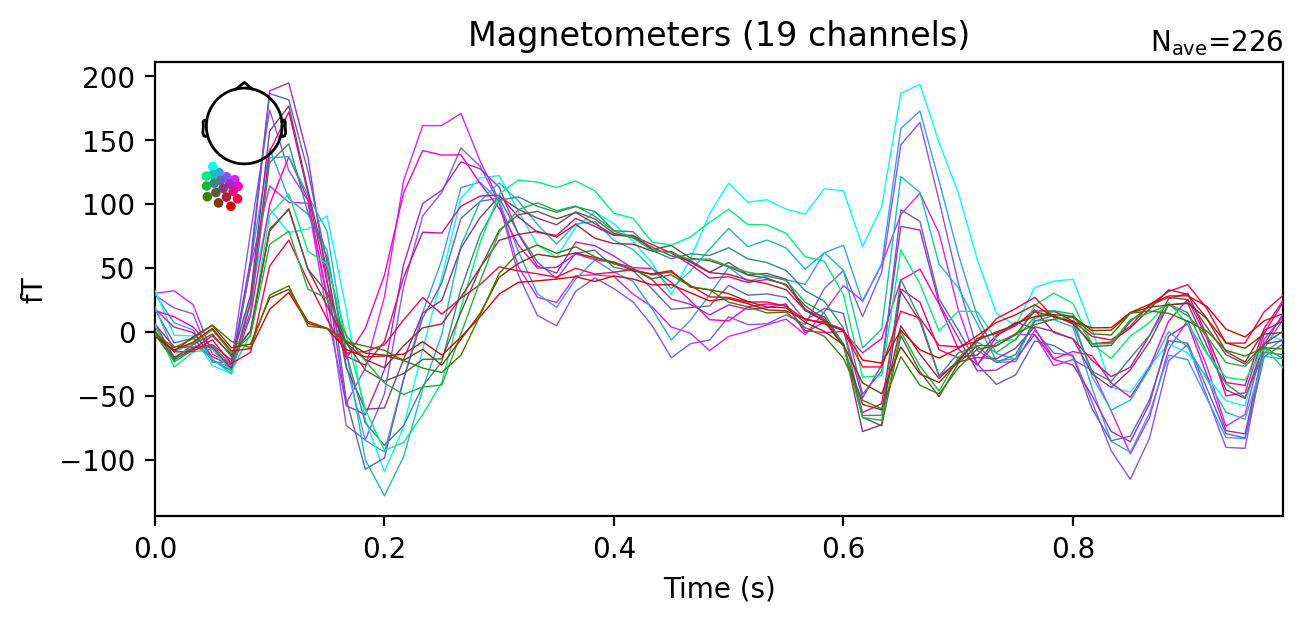

In [7]:
epochs.pick_channels(mag_ch_names[56:75]).average().plot();

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


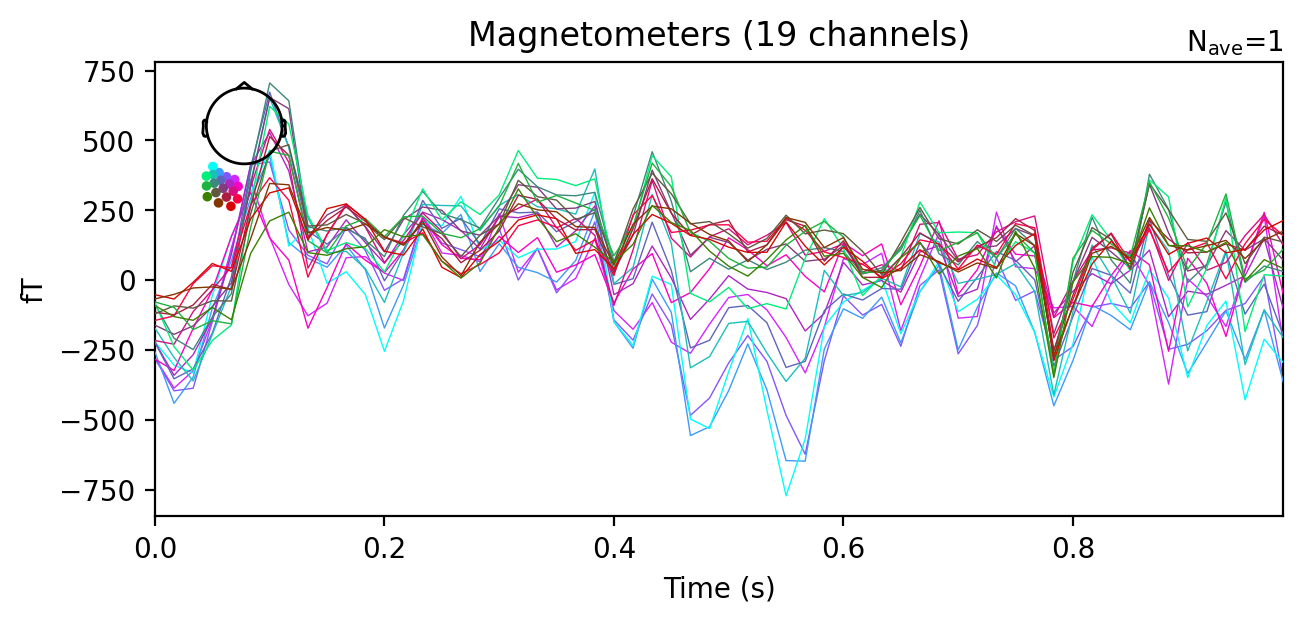

In [7]:
epochs[1].pick_channels(mag_ch_names[56:75]).average().plot();

In [50]:
train_meg = None
test_meg = None
for session, task, run in tqdm(product(sessions, tasks, runs), total=len(sessions)*len(tasks)*len(runs)):
    bids_path = BIDSPath(
        subject=subject,
        session=session,
        task=task,
        root=data_dir,
        run = run,
        datatype="meg",
    )
    raw = read_raw_bids(bids_path, verbose='ERROR')
    raw.set_channel_types(ch_type_map, verbose='ERROR')
    events, event_dict = mne.events_from_annotations(raw, verbose='ERROR')
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=1.0, baseline=(-0.3, 0), preload=True, picks='stim', verbose='ERROR')#.resample(60, npad="auto", verbose='ERROR')
    # epochs.crop(tmin=0.0, tmax=epochs.tmax, verbose=False);
    break

  0%|          | 0/120 [01:38<?, ?it/s]


In [51]:
# epochs.average(picks='stim').plot();

ValueError: Number of rows must be a positive integer, not 0

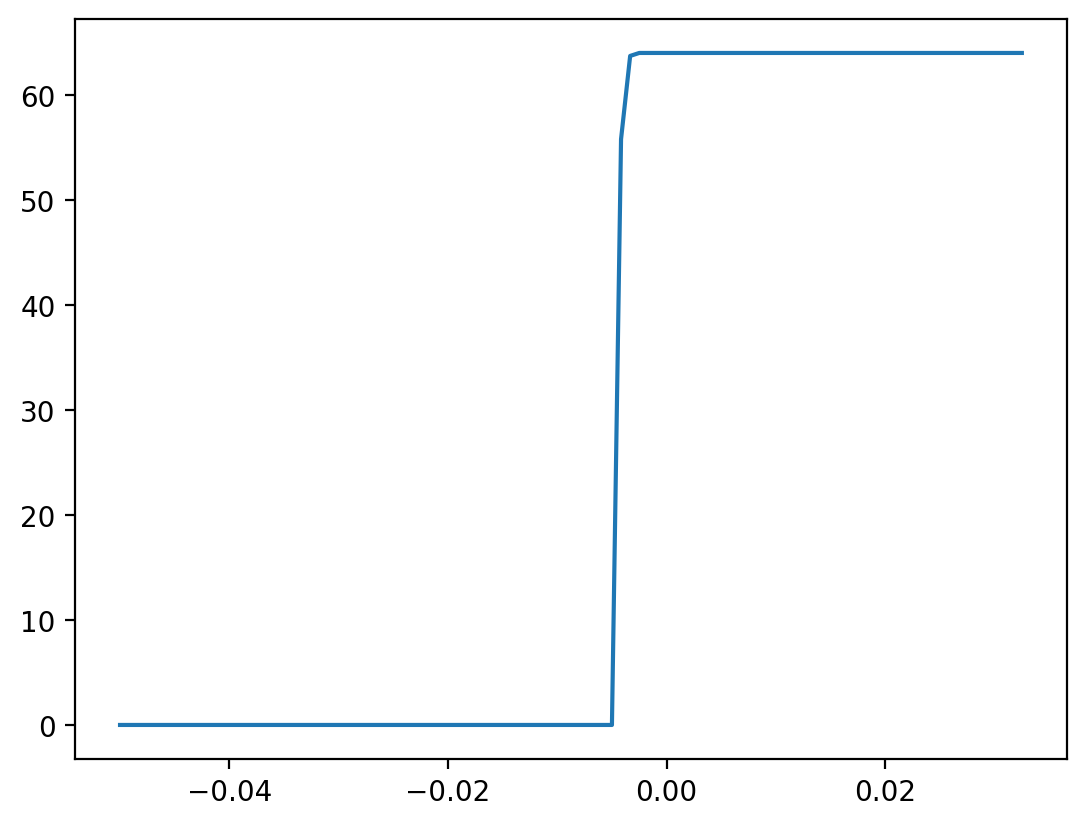

In [62]:
x = np.linspace(-0.3, 1.0, int(1.3*1200)+1)
plt.plot(x[300:400], epochs.average(picks='stim').get_data()[0][300:400])
plt.show()

In [63]:
epochs.average(picks='stim').get_data()[0][300:400]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       55.78761062, 63.71681416, 64.        , 64.        , 64.        ,
       64.        , 64.        , 64.        , 64.        , 64.        ,
       64.        , 64.        , 64.        , 64.        , 64.  

In [28]:
epochs.info["sfreq"]

120.0

In [123]:
epochs['exp'].get_data(copy=True).shape, epochs['test'].get_data(copy=True).shape

((186, 272, 120), (20, 272, 120))

In [116]:
# epochs['exp'].pick_channels(mag_ch_names[56:75]).average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Removing 5 compensators from info because not all compensation channels were picked.
Effective window size : 1.707 (s)


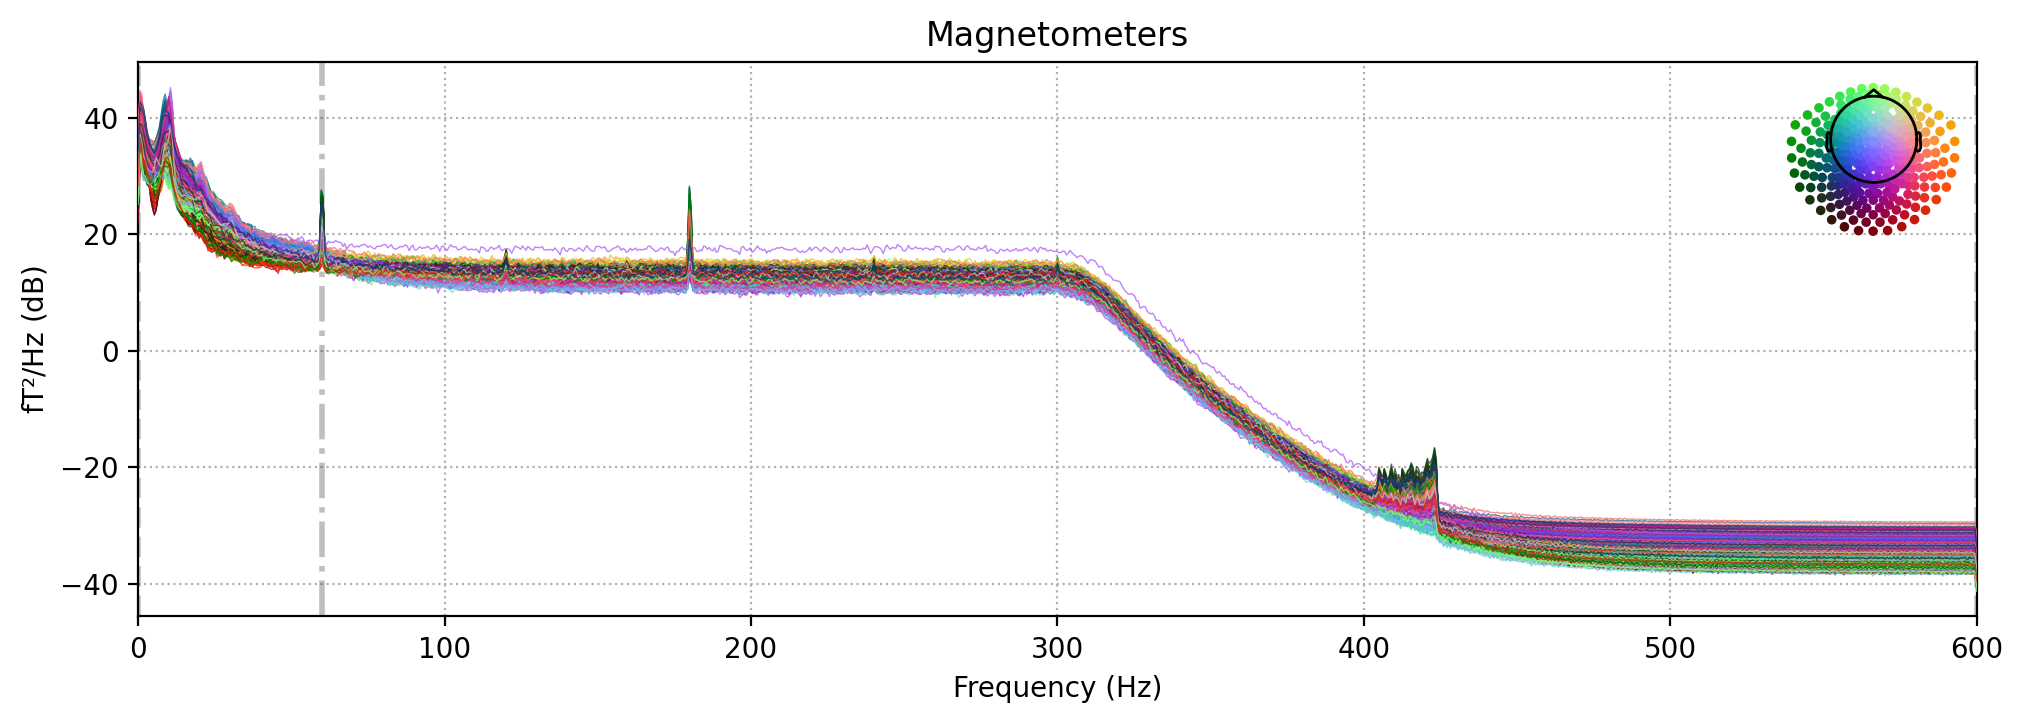

In [37]:
raw.plot_psd();

In [55]:
# dict(zip(mag_ch_names, range(len(mag_ch_names))))

In [70]:
epochs['exp'].get_data(copy=True)

array([[[-3.94997689e-15, -1.76134622e-14, -9.51425033e-15, ...,
          8.05010740e-14,  1.56068677e-13,  1.98879384e-13],
        [-1.32369022e-14, -5.04963594e-14, -5.71453925e-14, ...,
          3.71803535e-14,  1.13621686e-13,  1.20534504e-13],
        [ 9.21488832e-14, -2.47504129e-14, -2.83422215e-14, ...,
          3.54712445e-14,  1.52193530e-13,  1.62828232e-13],
        ...,
        [-1.50215727e-13, -6.31266372e-14,  1.03435583e-13, ...,
          1.87133065e-13,  1.06472397e-13,  7.32719420e-14],
        [ 1.11443784e-14,  3.52421229e-15,  3.28521194e-14, ...,
          2.50070888e-13,  2.32279611e-13,  1.19670710e-13],
        [-3.68749962e-13, -2.37070155e-13, -3.26428940e-14, ...,
          1.25982665e-13,  2.13666363e-14, -9.76778534e-14]],

       [[ 6.01412331e-14,  1.87263306e-13,  2.38529675e-13, ...,
          3.04678818e-13,  2.24527634e-13,  2.44231487e-13],
        [-1.59276304e-14,  9.18593268e-14,  6.93628993e-14, ...,
          3.46041817e-13,  2.11582034e